# Analyse des prix des carburants

Voici un exemple décrit pas à pas qui montre comment on analyse des données publiques disponibles en ligne. Ici on va travailler sur le prix de différentes énergies à partir des données de la [base Pégase](http://developpement-durable.bsocom.fr/Statistiques/) du ministère du développement durable.

La première chose est de sauver les tables qui nous intéressent à savoir 
* les données mensuelles de l'énergie, tarifs domestiques, produits pétroliers. On sauve les données en cliquant sur l'icône dossier, on utilise le format ascii délimité par des points-virgules (.csv). Le fichier est nomé `pegase_prix_petrole_particulier.csv`. 
* le prix des importation de pétrole qu'on sauve au même format dans `pegase_import_petrole.csv`


### Préparer son environnement

Je suppose que tout est bien installé sur votre machine (cf [ici](https://docs.python.org/fr/3.9/installing/index.html) pour des explications). On commence donc par charger les bibliothèques Python dont j'ai besoin :

In [1]:
import numpy as np               # bibliothèque qui ajoute les tables
import pandas as pd              # bibliothèque qui ajoute les tableaux (tableurs)
import matplotlib.pyplot as plt  # bibliothèque graphique pour tracer des courbes

# commandes magiques Jupyter pour voir les graphiques dans cette page :
%matplotlib inline                           
%config InlineBackend.figure_format = 'retina'

### Préparation des données

On charge un fichier `.csv` avec la commande de Pandas `read_csv`. C'est l'équivalent d'ouvrir le fichier avec Excel ou LibreOffice et de répondre aux questions sur le formatage du fichier (séparteur est `;`, l'encodage du fichier est du `latin1`).
On ignore aussi les lignes qui ne nous intéressent pas.

In [2]:
energie = pd.read_csv("pegase_prix_petrole_particulier.csv", sep=";", encoding="latin1", skiprows=[0,1,3], header=None)
energie.head()

,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
0,Période,janv-83,févr-83,mars-83,avr-83,mai-83,juin-83,juil-83,août-83,sept-83,...,déc-20,janv-21,févr-21,mars-21,avr-21,mai-21,juin-21,juil-21,août-21,sept-21
1,Tarif d'une tonne de propane en citerne,566.34,556.23,556.23,576.4500000000001,586.5700000000001,586.5700000000001,586.5700000000001,586.5700000000001,606.79,...,-,-,-,-,-,-,-,-,-,-
2,100 kWh PCI de propane en citerne,4.43,4.39,4.36,4.55,4.58,4.58,4.6,4.6,4.71,...,-,-,-,-,-,-,-,-,-,-
3,Prix d'une tonne de propane,522.2131000000001,512.8908,512.8908,531.5353,540.8668,540.8668,540.8668,540.8668,559.5114,...,1872.4482,1859.8505,1881.1189,1887.3258,1888.6143,1886.6555,1809.2635,1899.858,1808.0997,-
4,100 kWh PCS de propane,3.7842,3.7166,3.7166,3.8517,3.9193,3.9193,3.9193,3.9193,4.0544,...,13.5685,13.4772,13.6313,13.6763,13.6856,13.6714,13.1106,13.7671,13.1022,-


Le tableau est mal orienté ! Pour nous il faut que ce qui sera l'axe des x soit l'index vertical et que les noms des différentes courbes soient les noms des colonnes. On indique que la colonne `0` contient le nom des colonnes et on utilise `T` pour transposer le tableau.

In [3]:
energie = energie.set_index(0).T
energie.head(2)

,Période,Tarif d'une tonne de propane en citerne,100 kWh PCI de propane en citerne,Prix d'une tonne de propane,100 kWh PCS de propane,100 kWh PCI de propane,Bouteille de butane de 13 kg,100 litres de FOD au tarif C1,100 kWh PCI de FOD au tarif C1,Un litre d'essence ordinaire,Un litre de super carburant ARS,Un litre de super sans plomb 95,Un litre de super sans plomb 98,Un litre de gazole,Un litre de GPLc
1,janv-83,566.34,4.43,522.2131000000001,3.7842,4.0862,9.880000000000001,40.82,4.1182,0.66,0.7,-,-,0.55,-
2,févr-83,556.23,4.39,512.8908,3.7166,4.0132,9.880000000000001,40.23,4.0587,0.66,0.7,-,-,0.55,-


C'est mieux mais l'index ne contient toujours pas les dates et la colonne `Période` n'est pas formatée pour une machine. Aussi
on construit la fonction `conv_date` pour convertir une chaîne de caratères comme `janv-83` en une donnée de type date pour Python. On construit une nouvelle colonne appelée `date` en appliquant cette fonction à tous les éléments de la colonne `Période` :

In [4]:
import dateutil as du    # a une fonction qui transforme une chaîne de caratères bien écrite en une date

mois = {'janv':1, 'févr':2, 'mars':3, 'avr':4, 'mai':5, 'juin':6, 'juil':7, 'août':8, 'sept':9, 'oct':10, 'nov':11, 'déc':12}

def conv_date(d):
    ma = d.split('-')                                      # coupe la chaine au - et ainsi ma[0] est le mois et ma[1] l'année
    return du.parser.parse(f"15-{mois[ma[0].lower()]}-{ma[1]}")  # parfois le mois a une majuscule d'où lower()
    
energie['date'] = energie['Période'].apply(conv_date)

Maintenant on peut indiquer que l'index doit être la colonne `date` et qu'on n'a plus besoin de la colonne `Période` :

In [5]:
energie = energie.set_index('date')
energie.drop(columns=['Période'], inplace=True)
energie

,Tarif d'une tonne de propane en citerne,100 kWh PCI de propane en citerne,Prix d'une tonne de propane,100 kWh PCS de propane,100 kWh PCI de propane,Bouteille de butane de 13 kg,100 litres de FOD au tarif C1,100 kWh PCI de FOD au tarif C1,Un litre d'essence ordinaire,Un litre de super carburant ARS,Un litre de super sans plomb 95,Un litre de super sans plomb 98,Un litre de gazole,Un litre de GPLc
date,,,,,,,,,,,,,,
1983-01-15,566.34,4.43,522.2131000000001,3.7842,4.0862,9.880000000000001,40.82,4.1182,0.66,0.7,-,-,0.55,-
1983-02-15,556.23,4.39,512.8908,3.7166,4.0132,9.880000000000001,40.23,4.0587,0.66,0.7,-,-,0.55,-
1983-03-15,556.23,4.36,512.8908,3.7166,4.0132,9.880000000000001,39.19,3.9538,0.65,0.69,-,-,0.54,-
1983-04-15,576.4500000000001,4.55,531.5353,3.8517,4.1591,10.14,39.19,3.9538,0.65,0.69,-,-,0.54,-
1983-05-15,586.5700000000001,4.58,540.8668,3.9193,4.2321,10.14,39.49,3.9841,0.68,0.73,-,-,0.56,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-15,-,-,1886.6555,13.6714,14.7626,34.95,86,8.676399999999999,-,-,1.525,1.588,1.391,0.843
2021-06-15,-,-,1809.2635,13.1106,14.157,34.74,87.3,8.807499999999999,-,-,1.536,1.598,1.415,0.846
2021-07-15,-,-,1899.858,13.7671,14.8659,35.07,89.956,9.0755,-,-,1.5745,1.6362,1.4395,0.8509


Le tableau commemce à ressembler à ce qu'on souhaite. Il ne reste plus qu'à transformer les `-` en une non valeur pour Python à savoir un `NaN` (not a number), puis à convertir tous ces nombres qui sont du texte en réels (`float`).

In [6]:
energie = energie.replace('-', np.nan).astype('float')

On range tout ce qu'on vient de faire dans une fonction qui nous servira pour lire d'autres 
fichiers de la base Pégase.

In [7]:
def make_dataframe_from_pegase(filename):
    df = pd.read_csv(filename, sep=";", encoding="latin1", skiprows=[0,1,3], header=None)
    df = df.set_index(0).T
    df['date'] = df['Période'].apply(conv_date)
    df = df.set_index('date')
    df.drop(columns=['Période'], inplace=True)
    df = df.replace('-', np.nan).astype('float')
    return df

### Affichage

Maintenant on peut afficher une colonne sous forme de courbe :

<AxesSubplot:xlabel='date'>

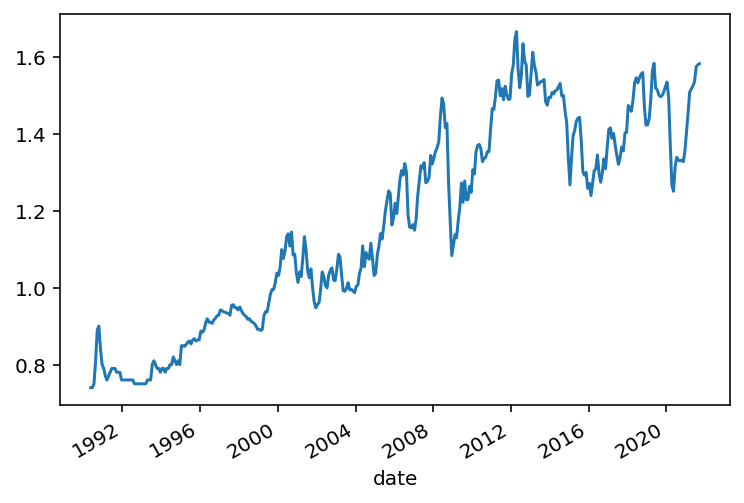

In [8]:
energie['Un litre de super sans plomb 95'].plot()

On note que les données sur l'essence sans plomb 95 commencent vers 1992. Aussi pour avoir un affichage plus joli lorsqu'on affiche cette courbe avec d'autres qui commenceraitent plus tôt, on définit les tableaux `energie92` et `importation92` qui commencent
en 1992.

In [9]:
importation = make_dataframe_from_pegase('pegase_import_petrole.csv')

energie92 = energie.loc['1992':]
importation92 = importation.loc['1992':]

lpt = 1161 # il y a 1161 litres par tonne de pétrole

On affiche le prix du SP 95, le prix du litre de pétrole importé et la différence entre les deux :

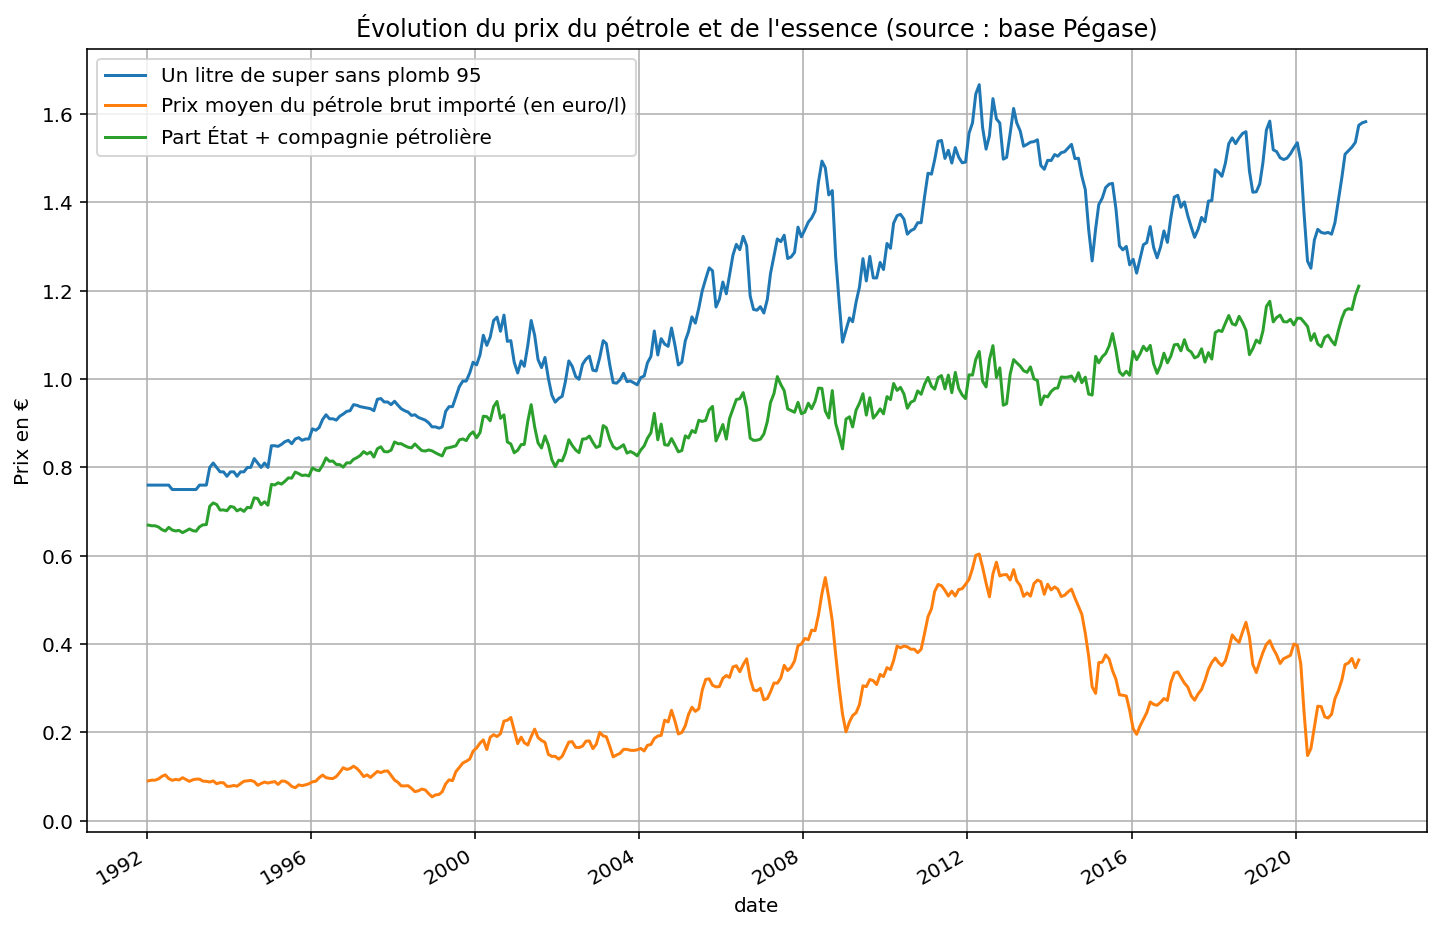

In [10]:
fig = plt.figure(figsize=(12,8))
energie92['Un litre de super sans plomb 95'].plot()
(importation92['Prix moyen du pétrole brut importé (en euro/t)'] / lpt).plot(label='Prix moyen du pétrole brut importé (en euro/l)')
(energie92['Un litre de super sans plomb 95'] - importation92['Prix moyen du pétrole brut importé (en euro/t)'] / lpt).plot(label="Part État + compagnie pétrolière")
plt.title("Évolution du prix du pétrole et de l'essence (source : base Pégase)")
plt.ylabel('Prix en €')
plt.grid()
plt.legend()
plt.show()

On constate que la part de l'État et des compagnies pétrolières a augmenté de 80 %.

Il faut relativiser sachant que l'inflation a augmenté de 50 % dans le même temps, mais quand
même cela fait 30 % d'augmentation sur un produit qui ne doit pas coûter plus cher à transformer, au contraire.

### Normer pour comparer

Si on veut comparer la progression de deux colonnes très différentes, le mieux est de choisir une date de référence puis de diviser les prix par le prix à cette date. Ainsi les deux courbes valent 1 à la date de référence et la variation des prix peut être comparer que l'on parle d'un litre d'un coté et d'une tonne de l'autre :

In [11]:
df = energie92.copy()
df /= df.loc[f"1992-01-15"]  # on met tout à 1 en janvier 1992

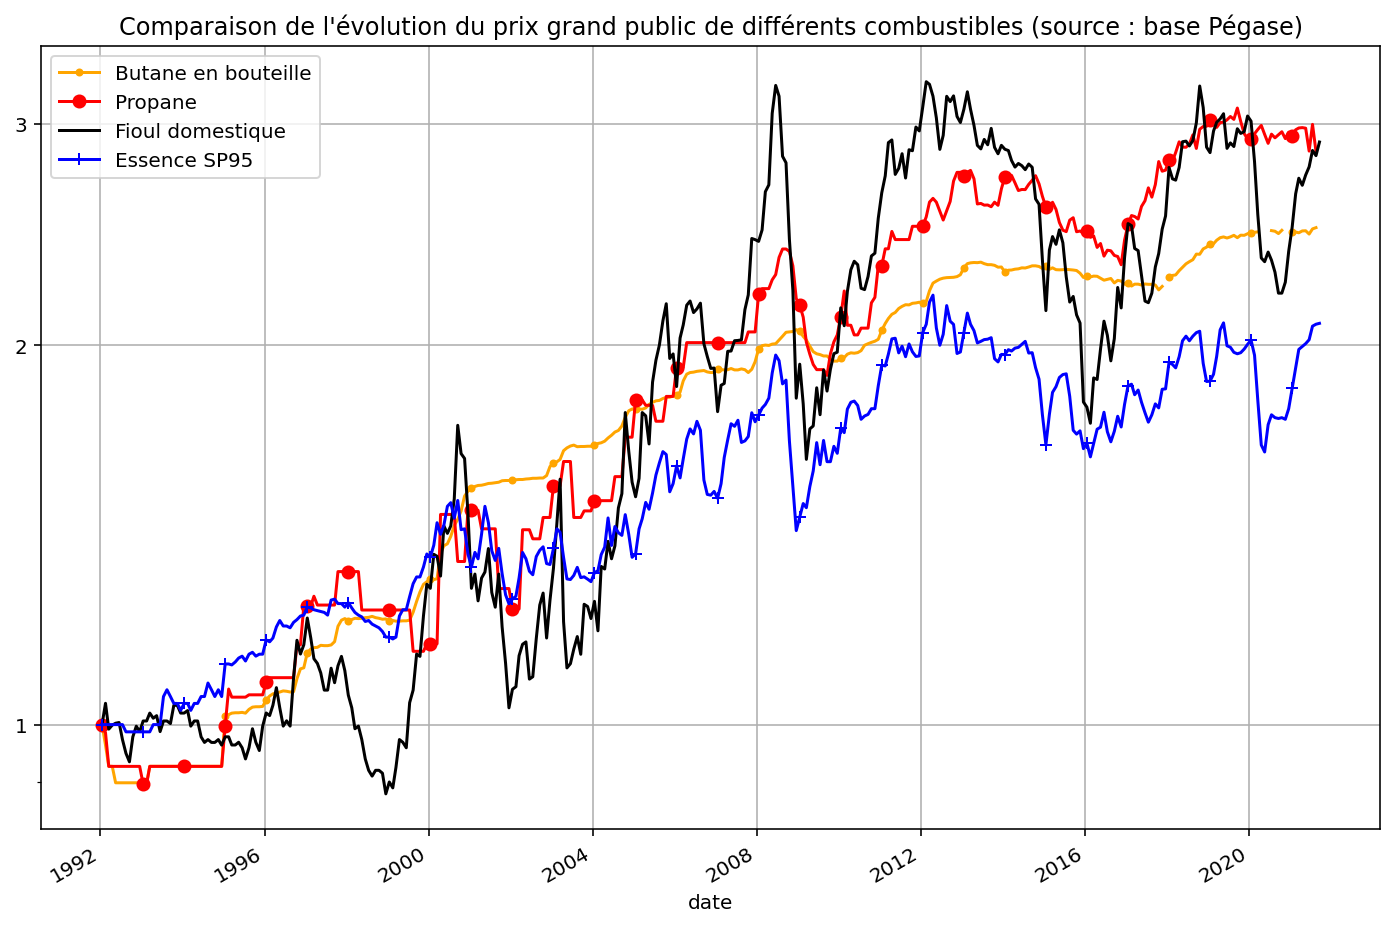

In [12]:
fig = plt.figure(figsize=(12,8))
df["Bouteille de butane de 13 kg"].plot(color='orange', style='.-', markevery=12, 
                                        label="Butane en bouteille")
df["Prix d'une tonne de propane"].plot(color='red', style='o-', markevery=12,
                                       label="Propane")
df["100 kWh PCI de FOD au tarif C1"].plot(color='black', style="-", markevery=12,
                                          label="Fioul domestique")
df['Un litre de super sans plomb 95'].plot(color='blue', style='-+', markevery=12,
                                           label="Essence SP95")
plt.title("Comparaison de l'évolution du prix grand public de différents combustibles (source : base Pégase)")
plt.yscale('log')
plt.yticks([1,2,3], [1,2,3])
plt.legend()   
plt.grid()
plt.show()

L'essence est l'énergie qui a le moins augmenté des quatres sur les 30 dernières années (x2 pour l'essence, x3 pour le fioul et le propane). Durant la même période
[le prix de l'essence aux État-Unis](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_NUS_DPG&f=W) a triplé mais reste 2 fois moins cher qu'en France.

On note l'éćhelle logarithmique qui permet de bien voir les variations en pourcentage. Ainsi
passer de x2 à x3 a le même écart que de x1 à x1,5. C'est 50 % d'augmentation dans les deux cas.

Les symboles (rond, croix) permettent de mieux voir l'image en noir et blanc.